In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
# Load dataset
df = pd.read_csv("../data/raw/global_electricity_production_data.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

print(df.info())
print(df['product'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121074 entries, 0 to 121073
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country_name  121074 non-null  object        
 1   date          121074 non-null  datetime64[ns]
 2   parameter     121074 non-null  object        
 3   product       121074 non-null  object        
 4   value         121060 non-null  float64       
 5   unit          121074 non-null  object        
 6   year          121074 non-null  int32         
 7   month         121074 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 6.5+ MB
None
['Electricity' 'Total Combustible Fuels'
 'Coal, Peat and Manufactured Gases' 'Oil and Petroleum Products'
 'Natural Gas' 'Combustible Renewables' 'Hydro' 'Wind' 'Solar'
 'Total Renewables (Hydro, Geo, Solar, Wind, Other)'
 'Other Combustible Non-Renewables' 'Geothermal' 'Not Specified' 'Nucle

## Feature: `product`
**Definition:**  
Indicates the **energy source** or **fuel type** used to produce electricity, measured in **GWh (Gigawatt-hours)**.

Electricity generation data in this dataset comes from the IEA’s *World Energy Balances* and related open data series, which track net production by energy source across all reporting countries and months.

---

### Product Categories and Descriptions

| **Product Name** | **Description** |
|------------------|------------------|
| **Electricity** | Total electricity generation from all sources. Serves as the aggregate sum across all fuel types. |
| **Total Combustible Fuels** | Combined generation from all fossil and bio-based fuels: coal, oil, natural gas, and biofuels. Represents thermal generation. |
| **Coal, Peat and Manufactured Gases** | Generation from coal-based fuels (hard coal, lignite, peat) and derived gases like coke oven gas or blast furnace gas. High CO₂ intensity. |
| **Oil and Petroleum Products** | Electricity produced from crude oil and refined petroleum fuels (diesel, heavy fuel oil, etc.). Often used for backup generation. |
| **Natural Gas** | Power generated from natural gas combustion. Lower CO₂ intensity than coal or oil, often used in combined-cycle plants. |
| **Biofuels and Waste** | Generation from solid biomass, biogas, municipal waste, and industrial waste. Includes renewable and non-renewable portions depending on feedstock. |
| **Hydro** | Electricity generated by hydropower plants using water flow through turbines. Renewable, dispatchable, but climate-dependent. |
| **Geothermal** | Electricity from underground heat sources (steam or hot water reservoirs). Low emissions, constant base-load output. |
| **Solar Photovoltaic** | Generation from photovoltaic (PV) cells converting sunlight directly into electricity. Intermittent, zero direct emissions. |
| **Solar Thermal** | Electricity from concentrated solar power (CSP) plants that use mirrors to generate heat for turbines. Renewable but geographically limited. |
| **Wind** | Power produced from wind turbines converting kinetic wind energy to electricity. Intermittent and weather-dependent. |
| **Tide, Wave and Ocean** | Experimental or small-scale generation from oceanic sources: tidal streams, waves, ocean currents, and thermal gradients. Renewable and location-specific. |
| **Nuclear** | Electricity generated through controlled nuclear fission reactions. Low CO₂ but includes waste and safety concerns. |
| **Other Sources** | Any other minor or unspecified electricity sources (e.g., hydrogen, synthetic fuels, pilot technologies). Typically small in share. |

---

### Analytical Relevance

| **Cluster Feature** | **Use in Analysis** |
|----------------------|--------------------|
| Fossil-based categories (Coal, Oil, Gas) | Measure carbon intensity and fossil dependence. |
| Renewable categories (Hydro, Wind, Solar, Geothermal, Tide) | Represent clean and sustainable generation capacity. |
| Transitional sources (Biofuels and Waste) | Capture mixed renewable/non-renewable generation. |
| Nuclear | Indicates low-carbon but non-renewable pathway reliance. |
| Aggregate totals | Used for normalization and consistency checks before computing generation shares. |

---

### Notes
- Some countries may not report all categories (missing = 0 or unmeasured).
- “Electricity” and “Total Combustible Fuels” are aggregate metrics and should not both be used as features in clustering (to avoid redundancy).
- Shares should always be normalized per country to total generation (100%) for comparability.

---

**Summary:**  
The `product` feature defines **what energy source** contributed to each record’s reported electricity production.  
In clustering, these categories form the **dimensions** of a country’s **energy-mix profile**, enabling comparison of fossil-heavy, renewable-dominant, and transition-stage energy systems worldwide.

In [5]:


# Identify the latest complete year in the dataset
latest_year = df['year'].max()
print(f"Latest year in dataset: {latest_year}")

# Filter to that year
df_latest = df[df['year'] == latest_year].copy()

# Aggregate by country and energy product
aggregated = (
    df_latest
    .groupby(['country_name', 'product'])
    .agg(
        total_GWh=('value', 'sum'),
        avg_GWh=('value', 'mean'),
        std_GWh=('value', 'std'),
        months_reported=('month', 'nunique')
    )
    .reset_index()
)

# Pivot to wide format for clustering later
aggregated_pivot = aggregated.pivot_table(
    index='country_name',
    columns='product',
    values='total_GWh',
    fill_value=0
)

print(aggregated_pivot.info())

Latest year in dataset: 2023
<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Argentina to United States
Data columns (total 16 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Coal, Peat and Manufactured Gases                  48 non-null     float64
 1   Combustible Renewables                             48 non-null     float64
 2   Data is estimated for this month                   48 non-null     float64
 3   Electricity                                        48 non-null     float64
 4   Geothermal                                         48 non-null     float64
 5   Hydro                                              48 non-null     float64
 6   Natural Gas                                        48 non-null     float64
 7   Not Specified                                      48 non-null     float64
 8   Nuclear                                          

## Why We Aggregated Across a Year

### Context
The raw dataset includes **monthly electricity generation values** for each **country and energy source**.  
To analyze national energy systems and perform clustering, we needed to represent **each country with a single, stable profile** rather than fluctuating monthly data.

---

### Rationale for Annual Aggregation

1. **Remove Seasonal Noise**
   - Monthly values capture short-term variability (e.g., hydro peaks, solar dips).
   - Annual totals smooth out seasonal fluctuations, highlighting *structural differences* between energy systems.

2. **Ensure Cross-Country Comparability**
   - Countries operate in different hemispheres and climates, so comparing January vs. July is misleading.
   - Aggregating to yearly totals ensures all countries are evaluated over the *same full production cycle*.

3. **Reflect Policy-Relevant Metrics**
   - Energy transition decisions are based on *annual generation shares* (e.g., % renewable electricity per year), not monthly patterns.
   - Policymakers use yearly data for SDG 7 and SDG 13 reporting and investment planning.

4. **Simplify Clustering Features**
   - Aggregation condenses 12×N observations into one record per country, enabling clustering on stable features (coal%, solar%, hydro%, etc.).
   - Reduces noise and avoids overfitting to short-term dynamics.

5. **Support Sustainability Insights**
   - Year-level aggregation highlights structural energy mix archetypes:
     - *Fossil-dominant systems*
     - *Renewable-transitioning systems*
     - *Hydro/nuclear-dependent systems*
   - These clusters are meaningful for long-term policy and investment, not month-to-month operations.

---

### Outcome
After aggregation:
- Each country is represented by **its total and average electricity production per energy source** for the **latest year**.
- The data now accurately reflects **annual energy mix composition**, ready for **clustering and sustainability analysis**.

## Missing Data Analysis

### 1. Pattern Analysis
We visualize the percentage and structure of missing data across all features to identify patterns and potential dependencies.


Missing Value Summary:


,Missing Count,Percent
product,,
"Coal, Peat and Manufactured Gases",0,0.000000
Combustible Renewables,0,0.000000
Data is estimated for this month,0,0.000000
Electricity,0,0.000000
Geothermal,0,0.000000
Hydro,0,0.000000
Natural Gas,0,0.000000
Not Specified,0,0.000000
Nuclear,0,0.000000


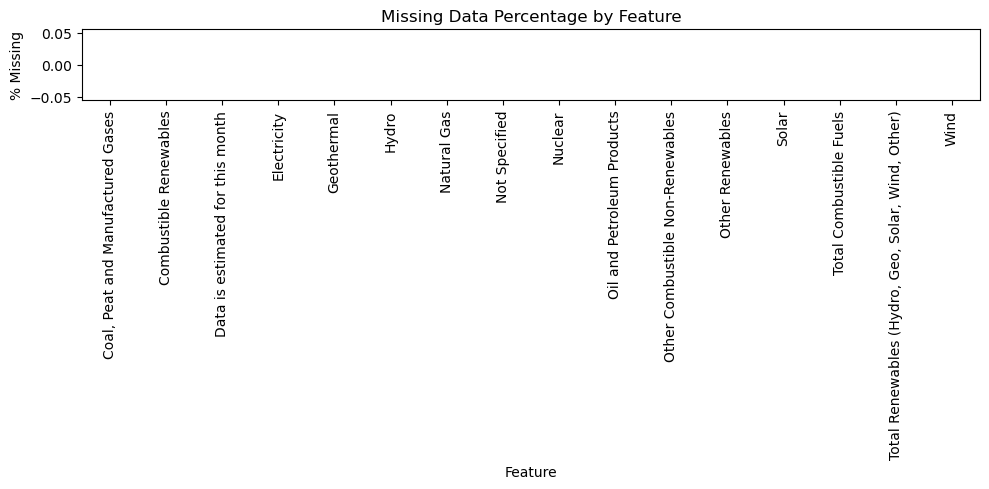

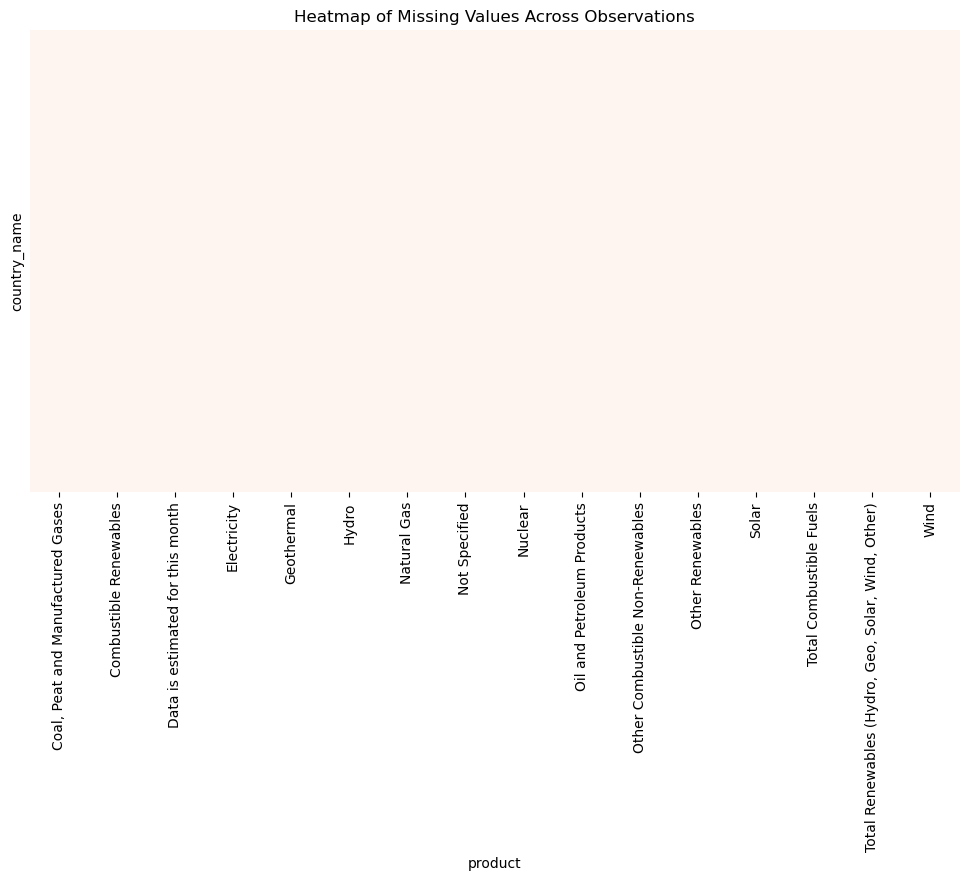

In [10]:
df_missing = aggregated_pivot.copy()

# Summary of missing data
missing_summary = df_missing.isna().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(df_missing)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Percent': missing_percent})

print("Missing Value Summary:")
display(missing_df.style.background_gradient(cmap="Reds"))

# Bar plot of missing percentages
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_percent.index, y=missing_percent.values, color="salmon")
plt.xticks(rotation=90)
plt.title("Missing Data Percentage by Feature")
plt.ylabel("% Missing")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Visual heatmap of missingness pattern
plt.figure(figsize=(12, 6))
sns.heatmap(df_missing.isna(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Heatmap of Missing Values Across Observations")
plt.show()


### Missing Data Summary

All features have complete observations across the 48 countries for the latest available year (2023).  
No missing or null values were detected in the aggregated dataset.

**Implications:**
- The aggregation and pivoting process successfully removed any earlier temporal gaps or incomplete monthly entries.
- No imputation strategies are needed at this stage.
- Clustering results can be interpreted without sensitivity concerns related to missing data assumptions (MCAR/MAR/MNAR).

**Next step:** Proceed directly to feature scaling and clustering analysis.
